In [33]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings
warnings.filterwarnings('ignore')

In [34]:
# Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [35]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [36]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [37]:
# Split into train, calibration and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train, X_penalty_test, y_penalty_train, y_penalty_test = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [38]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 1))

Shots train 51604 ;Number goals 5478 ;Goals %:  10.6
Shots test 12902 ;Number goals 1369 ;Goals %:  10.6


In [39]:
print('Penalty Shots train', len(y_penalty_train), ';Penalty Number goals', y_penalty_train.sum(),
      ';Penalty Goals %: ', round(y_penalty_train.mean()*100, 1))
print('Penalty Shots test', len(y_penalty_test), ';Penalty Number goals', y_penalty_test.sum(),
      ';Penalty Goals %: ', round(y_penalty_test.mean()*100, 1))

Penalty Shots train 656 ;Penalty Number goals 486 ;Penalty Goals %:  74.1
Penalty Shots test 165 ;Penalty Number goals 122 ;Penalty Goals %:  73.9


In [40]:
# Load and split fake data
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [9]:
print('Shots fake', len(y_fake), ';Goals %: ', round(y_fake.mean()*100, 1))

Shots fake 1000 ;Goals %:  3.4


# LightGBM model

In [10]:
# Add fake training data. I am not adding this to the test data as want this to be realistic of real data.
X_train = pd.concat([X_train, X_fake])
y_train = pd.concat([y_train, y_fake])

In [13]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)

In [14]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train = clean_lightgbm_p(X_penalty_train)
X_penalty_test = clean_lightgbm_p(X_penalty_test)

In [15]:
# Fit the nested 5-fold cross validation using Bayesian optimisation.
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3)
lgbm_param_grid = {'base_estimator__min_child_samples': Integer(0, 200),
                   'base_estimator__num_leaves': Integer(2, 500),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}
# Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725
searchcv = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
searchcv.fit(X_train, y_train)
# Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725
searchcv_p = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
searchcv_p.fit(X_penalty_train, y_penalty_train)

BayesSearchCV(cv=5,
              estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(random_state=42),
                                               cv=3, method='isotonic'),
              n_iter=100, n_jobs=-1,
              search_spaces={'base_estimator__max_depth': Integer(low=0, high=500, prior='uniform', transform='identity'),
                             'base_estimator__min_child_samples': Integer(low=0, high=200, prior='uniform', transform='identity'),
                             'base_estimator__num_leaves': Integer(low=2, high=500, prior='uniform', transform='identity'),
                             'base_estimator__reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'base_estimator__reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity')})

In [17]:
# Permutation importance
# note not using fake data for permutation importance
perm_result = permutation_importance(searchcv.best_estimator_, X_train, y_train, n_repeats=10, random_state=42)
df_perm_importance = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

In [18]:
perm_result_p = permutation_importance(searchcv_p.best_estimator_, X_penalty_train, y_penalty_train, n_repeats=10,
                                       random_state=42)
df_perm_importance_p = pd.DataFrame({'Feature':X_penalty_train.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

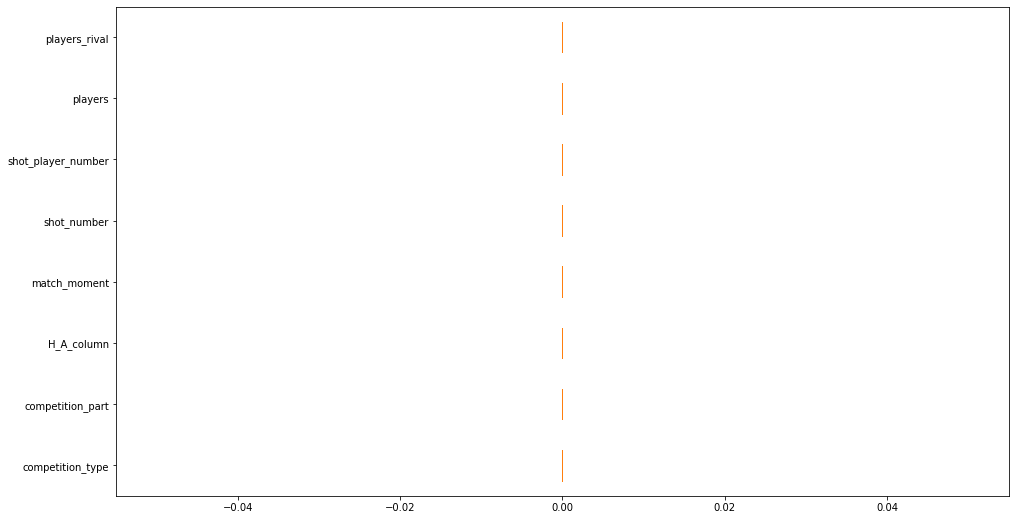

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train.columns[sorted_idx])

# Test

In [23]:
# Calculate calibration curve on test data
y_pred_lgbm_calibrated = searchcv.best_estimator_.predict_proba(X_test)
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test, y_pred_lgbm_calibrated[:, 1], n_bins=10)

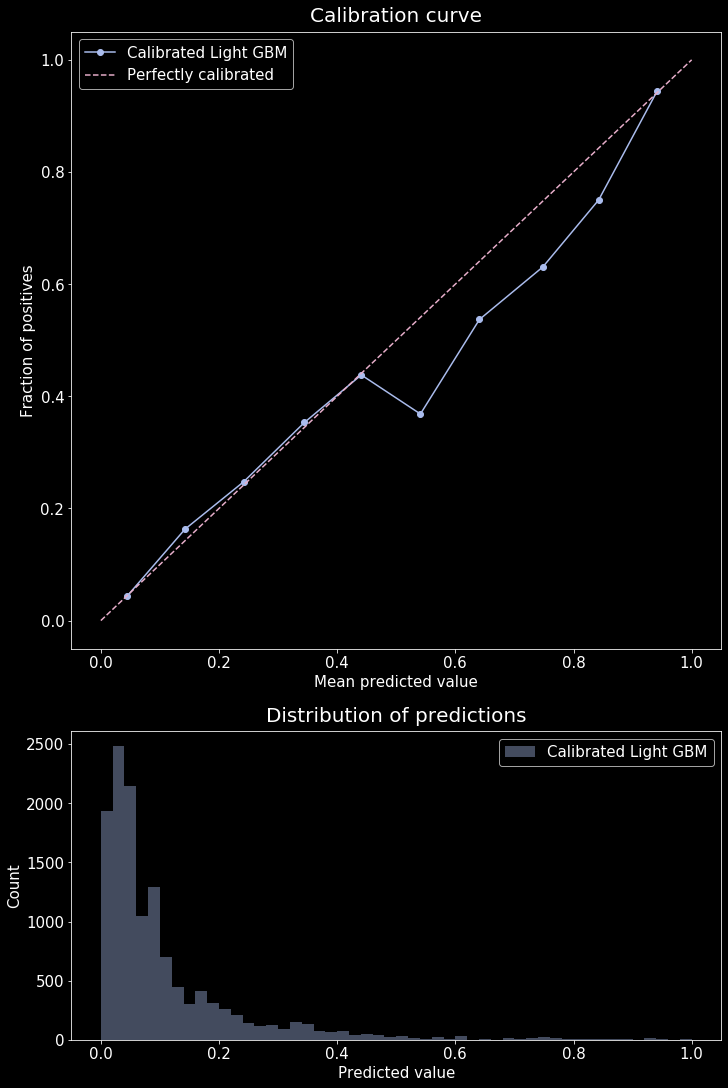

In [24]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm_calibrated[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve2.png'), bbox_inches = 'tight', pad_inches = 0.2)

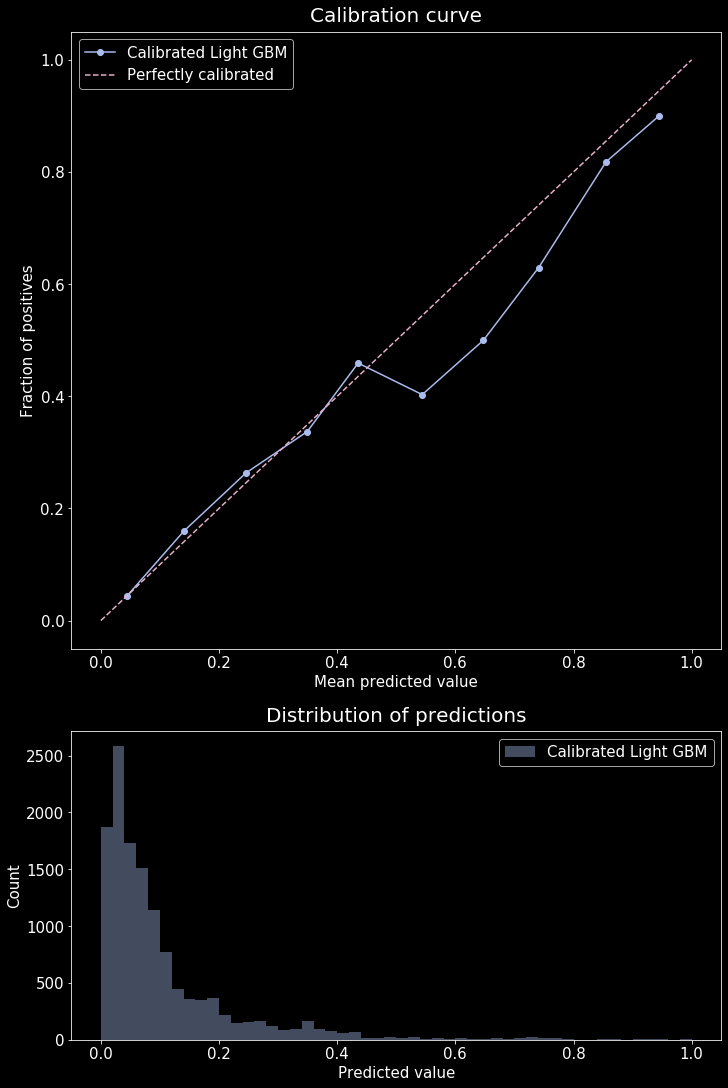

In [40]:
y_pred_lgbm_calibrated_p = searchcv_p.best_estimator_.predict_proba(X_penalty_test)
fraction_of_positives_lgbm_p, mean_predicted_value_lgbm_p = calibration_curve(y_penalty_test, y_pred_lgbm_calibrated_p[:, 1],
                                                                              n_bins=10)

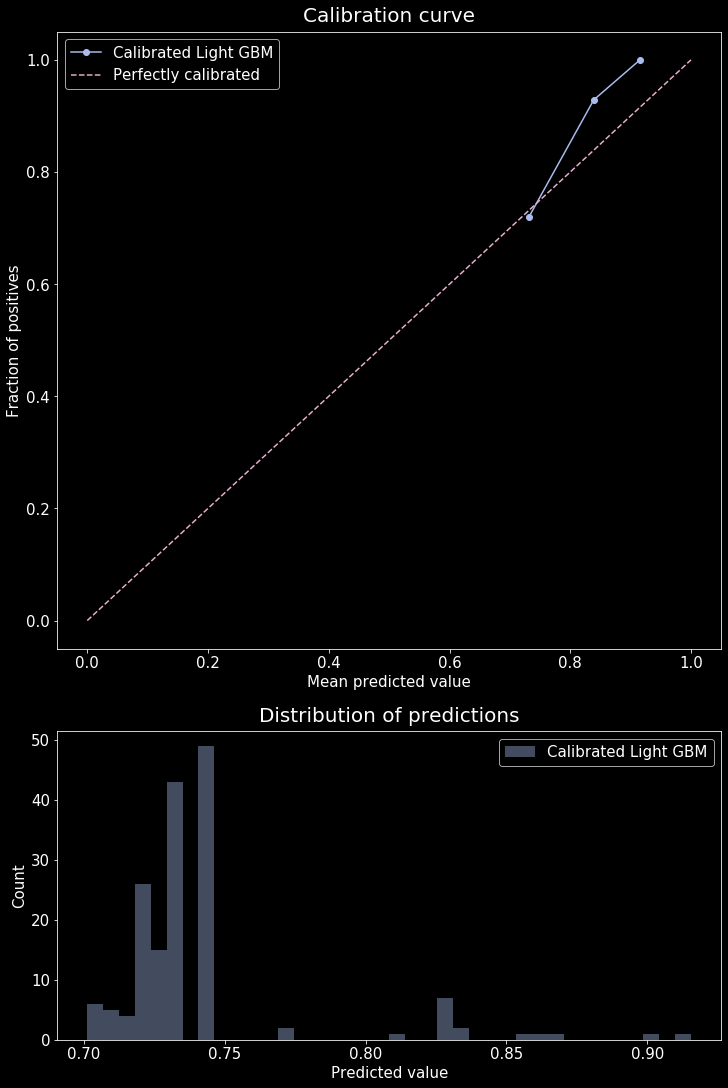

In [25]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm_p, fraction_of_positives_lgbm_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm_calibrated_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve_p2.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [26]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, y_pred_lgbm_calibrated)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, y_pred_lgbm_calibrated[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_test, y_pred_lgbm_calibrated[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_test, y_pred_lgbm_calibrated[:,1], pos_label=y_test.max()))

The log loss of the model with Random Search is: 0.2829582864791413
The ROC AUC score of the model with Random Search is: 0.7922674901766626
Pseudo R-squared, logistic regression: 0.16358546057045742
Brier score, logistic regression: 0.08128138748786573


From scikit-learn docs: "The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome."

In [27]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_penalty_test, y_pred_lgbm_calibrated_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_penalty_test,
                                                                                  y_pred_lgbm_calibrated_p[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_penalty_test, y_pred_lgbm_calibrated_p[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_penalty_test, y_pred_lgbm_calibrated_p[:,1], 
                                                           pos_label=y_penalty_test.max()))

The log loss of the model with Random Search is: 0.5656094090729998
The ROC AUC score of the model with Random Search is: 0.5528021349599695
Pseudo R-squared, logistic regression: 0.01408509120118151
Brier score, logistic regression: 0.18993092869611775


# Save models

In [28]:
dump(searchcv.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model.joblib']

In [ ]:
dump(searchcv_p.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model_penalty.joblib'))

# Save data

In [29]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_non_penalty = df[~mask_penalty].copy()

In [30]:
X_train['goal'] = y_train
X_train['split'] = 'train'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train, X_test])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))



X_penalty_train['goal'] = y_penalty_train
X_penalty_train['split'] = 'train'
X_penalty_test['goal'] = y_penalty_test
X_penalty_test['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train, X_penalty_test])
# exlcude fake shots
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty.index.isin(df_penalty.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm_penalty.parquet'))

In [31]:
df_lgbm_penalty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64506 entries, 37467 to 46286
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   competition_type         64506 non-null  int64  
 1   competition_part         64506 non-null  int64  
 2   H_A_column               64506 non-null  int64  
 3   match_moment             64506 non-null  int64  
 4   x                        64506 non-null  float64
 5   y                        64506 non-null  float64
 6   visible_angle            64506 non-null  float64
 7   middle_angle             64506 non-null  float64
 8   distance_to_goal         64506 non-null  float64
 9   distance_visible_angle   64506 non-null  float64
 10  log_distance_to_goal     64506 non-null  float64
 11  shot_type_name           64506 non-null  int64  
 12  shot_one_on_one          21843 non-null  float32
 13  shot_open_goal           21843 non-null  float32
 14  under_pressure         